## Model Based Curation Tutorial
#### This notebook provides a step-by-step guide on how to use machine learning classifier for curating spike sorted output into 'noise', multi-unit-activity' (MUA) and 'single-unit-activity' (SUA) using Spikeinterface. 


#### To use this, you should have already done spike sorting.
#### In this notebook we will compute quality metrics and load machine model to predict curation labels for previously uncurated electrophysiology data.
#### The classifier is trained on Neuropixels data from 11 mice recorded in V1,SC and ALM



In [19]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import os
from os import cpu_count
import json
# Set the number of CPU cores to be used globally - defaults to all cores -1
n_cores = cpu_count() -1
si.set_global_job_kwargs(n_jobs = n_cores)
print(f"Number of cores set to: {n_cores}")

# SET OUTPUT FOLDER
output_folder =  Path(r"E:\spikeinterface_outputs")

Number of cores set to: 23


In [ ]:
import spikeinterface
print(spikeinterface.__version__)

# Load data 

## First step: Loading the recording and sorting objects

For the tutorial, we are using simulated data to create recording and sorting objects.

In [22]:
# Generate a synthetic recording
recording = si.generate_recording(num_channels=50, sampling_frequency=30000.,
                               durations=[30], set_probe=True)
# load your recoring depeding on the acquistion software you used, for example:
# recording = se.read_spikeglx(recording_path, stream_name='imec0.ap')

# Generate a synthetic sorting
sorting = si.generate_sorting(num_units=100, sampling_frequency=30000., durations=[30],
                            firing_rates=15, refractory_period_ms=1.5)
# load your sorting depeding on the which spike sorter you used, for example:
# sorting = se.read_kilosort(folder_path)

## Second step: Create SortingAnalyzer 

SortingAnalyzer  is a postprocessing module which is used to compute quality metrics and template metrics.
To know more about it, please refer to : https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html

If you have already have WaveformExtractor from previous run, you can use it to create a SortingAnalyzer. 
Please refer to: https://spikeinterface.readthedocs.io/en/latest/tutorials/waveform_extractor_to_sorting_analyzer.html


In [ ]:
analyzer = si.create_sorting_analyzer(sorting = sorting, recording = recording, sparse = True)

## Third step: Compute metrics

Quality metrics serve as features for the machine learning model. We generate these metrics and use the model to predict labels based on them.

In [13]:
# Defines a function to compute all analyzer properties and quality metrics
# Note: this can be a time-consuming step, especially computing PCA-based metrics for long recordings

def compute_all_metrics(analyzer):

    # Compute required extensions for quality metrics
    analyzer.compute({
	'noise_levels': {},
	'random_spikes': {'max_spikes_per_unit': 1_000},
	'templates': {'ms_before': 1.5, 'ms_after': 3.5},
	'spike_amplitudes': {},
	'waveforms': {},
	'principal_components': {},
	'spike_locations': {},
	'unit_locations': {},
	})

    # Compute all available quality metrics
    analyzer.compute("quality_metrics", metric_names = sqm.get_quality_metric_list() + sqm.get_quality_pca_metric_list())
    analyzer.compute("template_metrics", metric_names = spost.get_template_metric_names())

	# Make metric dataframe
    quality_metrics = analyzer.extensions['quality_metrics'].data["metrics"]
    template_metrics = analyzer.extensions['template_metrics'].data["metrics"]
    calculated_metrics = pd.concat([quality_metrics, template_metrics], axis = 1)

    return calculated_metrics

In [ ]:
# Compute all metrics
metrics = compute_all_metrics(analyzer)
metrics.index.name = 'cluster_id'

In [ ]:
# save the analyzer
analyzer.save_as(folder=output_folder / 'sorting_analyzer', format="binary_folder")

## Load a pretrained model from the Hugging Face Hub

## First we use noise vs neuron classifier

In [20]:
analyzer = si.load_sorting_analyzer(folder= output_folder / 'sorting_analyzer', format="binary_folder")

In [21]:
import skops.io as sio
from huggingface_hub import hf_hub_download

model_path = hf_hub_download("AnoushkaJain3/curation_machine_learning_models", "noise_neuron_model.skops")
untrusted_types = sio.get_untrusted_types(file=model_path)

# Load pretrained noise/neural activity model and predict on unlabelled data
from spikeinterface.curation.model_based_curation import auto_label_units

label_conversion = {1: 'noise',0: 'neuron'}

label_dict_noise =  auto_label_units(sorting_analyzer = analyzer,
                             repo_id = "AnoushkaJain3/curation_machine_learning_models",
                             model_name= 'noise_neuron_model.skops',
                             label_conversion=label_conversion,
                             trusted= untrusted_types
                            )

C:\Users\jain\Documents\Github_extend\spikeinterface\src\spikeinterface\curation\model_based_curation.py:353: UserWarning: No 'model_info.json' file found in folder. No metadata can be checked.
  warnings.warn("No 'model_info.json' file found in folder. No metadata can be checked.")


## Second we use sua vs mua classifier

In [22]:
model_path = hf_hub_download("AnoushkaJain3/curation_machine_learning_models", "sua_mua_model.skops")
untrusted_types = sio.get_untrusted_types(file=model_path)

label_conversion = {1: 'sua',0: 'mua'}

label_dict_sua=  auto_label_units(sorting_analyzer = analyzer,
                             repo_id = "AnoushkaJain3/curation_machine_learning_models",
                             model_name= 'sua_mua_model.skops',
                             label_conversion=label_conversion,
                             trusted= untrusted_types
                            )

C:\Users\jain\Documents\Github_extend\spikeinterface\src\spikeinterface\curation\model_based_curation.py:353: UserWarning: No 'model_info.json' file found in folder. No metadata can be checked.
  warnings.warn("No 'model_info.json' file found in folder. No metadata can be checked.")


## Combine the predictions and probabilities from the two models

In [23]:
# Combine data
decoder_output = {}

for key, value in label_dict_noise.items():
    label, prob1 = value
    if label == 'noise':
        decoder_output[key] = (label, prob1)  # Keep 'noise' and its probability
    else:
        sua_mua_label, prob2 = label_dict_sua[key]    # Get 'sua' or 'mua' label and its probability
        decoder_output[key] = (sua_mua_label, prob2)  # Replace 'neuron' with 'sua'/'mua' and their probabilities

# Print the resulting combined data
print(decoder_output)

# Save the decoder output
with open(output_folder / 'decoder_output.json', 'w') as f:
    json.dump(decoder_output, f)

{0: ('noise', 0.6136904761904761), 1: ('noise', 0.5225), 2: ('noise', 0.6099285714285715), 3: ('noise', 0.6553571428571427), 4: ('noise', 0.6146904761904761), 5: ('noise', 0.6320238095238095), 6: ('noise', 0.6036904761904761), 7: ('noise', 0.6036904761904761), 8: ('noise', 0.7125), 9: ('noise', 0.6025), 10: ('noise', 0.5891666666666666), 11: ('noise', 0.6911666666666666), 12: ('noise', 0.7113571428571429), 13: ('noise', 0.6826904761904761), 14: ('noise', 0.6248333333333334), 15: ('noise', 0.6308333333333335), 16: ('noise', 0.5936904761904762), 17: ('noise', 0.6193571428571428), 18: ('noise', 0.5803571428571428), 19: ('noise', 0.5836904761904761), 20: ('noise', 0.6753571428571428), 21: ('noise', 0.5824999999999999), 22: ('noise', 0.6633333333333333), 23: ('noise', 0.6806904761904762), 24: ('noise', 0.6986904761904762), 25: ('noise', 0.7125), 26: ('noise', 0.6036904761904761), 27: ('noise', 0.6633571428571429), 28: ('noise', 0.6958333333333333), 29: ('noise', 0.6136904761904761), 30: ('n

## Assess model performance by comparing with human labels

To assess the performance of the model relative to human labels, we can load (or here generate randomly) some labels, and plot a confusion matrix of predicted vs human labels for all clusters

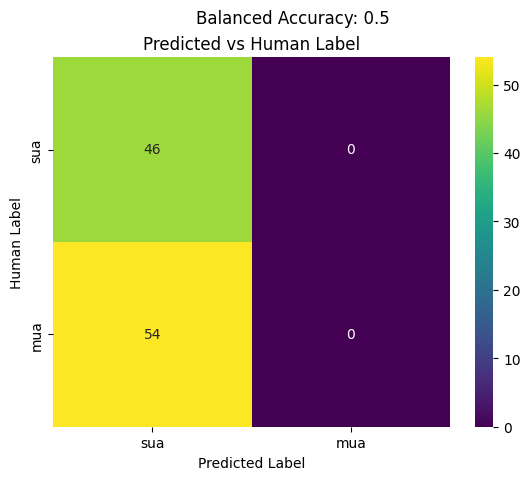

In [24]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import seaborn as sns

# Use 'ground-truth' labels to check prediction accuracy
# These are assigned randomly here but you could load these from phy 'cluster_group.tsv', from the 'quality' property of the sorting, or similar
human_labels = np.random.choice(list(label_conversion.values()), analyzer.get_num_units())

# Get labels from phy sorting (if loaded) using:
# human_labels = unlabelled_analyzer.sorting.get_property('quality')

predictions = analyzer.sorting.get_property('label_prediction')

conf_matrix = confusion_matrix(human_labels, predictions)

# Calculate balanced accuracy for the confusion matrix
balanced_accuracy = balanced_accuracy_score(human_labels, predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Human Label')
plt.xticks(ticks = [0.5, 1.5], labels = list(label_conversion.values()))
plt.yticks(ticks = [0.5, 1.5], labels = list(label_conversion.values()))
plt.title('Predicted vs Human Label')
plt.suptitle(f"Balanced Accuracy: {balanced_accuracy}")
plt.show()

We can also see how the model's confidence relates to the probability that the model label matches the human label

This could be used to set a threshold above which you might accept the model's classification, and only manually curate those which it is less sure of

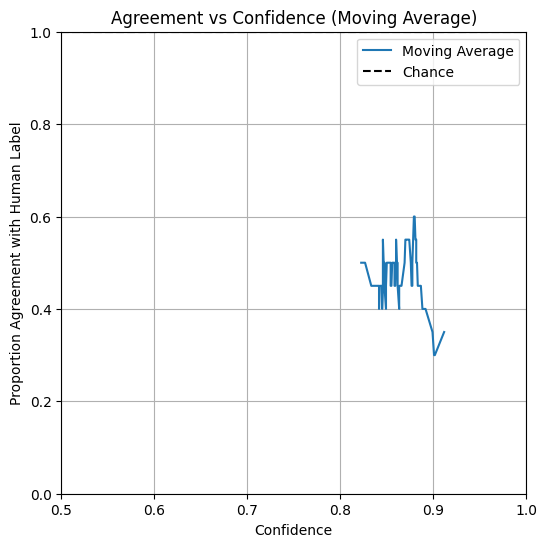

In [25]:
confidences = analyzer.sorting.get_property('label_confidence')

# Make dataframe of human label, model label, and confidence
label_df = pd.DataFrame(data = {
    'phy_label': human_labels,
    'decoder_label': predictions,
    'confidence': confidences},
    index = decoder_output.keys())

# Calculate the proportion of agreed labels by confidence decile
label_df['model_x_human_agreement'] = label_df['phy_label'] == label_df['decoder_label']

def calculate_moving_avg(label_df, confidence_label, window_size):

    label_df[f'{confidence_label}_decile'] = pd.cut(label_df[confidence_label], 10, labels=False, duplicates='drop')
    # Group by decile and calculate the proportion of correct labels (agreement)
    p_label_grouped = label_df.groupby(f'{confidence_label}_decile')['model_x_human_agreement'].mean()
    # Convert decile to range 0-1
    p_label_grouped.index = p_label_grouped.index / 10
    # Sort the DataFrame by confidence scores
    label_df_sorted = label_df.sort_values(by=confidence_label)

    p_label_moving_avg = label_df_sorted['model_x_human_agreement'].rolling(window=window_size).mean()

    return label_df_sorted[confidence_label], p_label_moving_avg

p_agreement_sorted, p_agreement_moving_avg = calculate_moving_avg(label_df, 'confidence', 20)

# Plot the moving average of agreement
plt.figure(figsize=(6, 6))
plt.plot(p_agreement_sorted, p_agreement_moving_avg, label = 'Moving Average')
plt.axhline(y=1/len(np.unique(predictions)), color='black', linestyle='--', label='Chance')
plt.xlabel('Confidence'); plt.xlim(0.5, 1)
plt.ylabel('Proportion Agreement with Human Label'); plt.ylim(0, 1)
plt.title('Agreement vs Confidence (Moving Average)')
plt.legend(); plt.grid(True); plt.show()

# If you only have metrics files

If you don't have access to to sorting analyzer for a particular recording, you can still use the pretrained model to predict on a new data

In [2]:
# Load your files

data_directory = Path(r"Y:\invivo_ephys\Neuropixels")
recording_folder = '2838_20240620'
metrics_folder = data_directory / recording_folder / 'metrics'


In [3]:
# load quality metrics and template metrics csv files

quality_metrics = pd.read_csv(metrics_folder / 'quality_metrics.csv')
template_metrics = pd.read_csv(metrics_folder / 'template_metrics.csv')

# merge them based on the index
metrics = pd.merge(quality_metrics, template_metrics, left_index=True, right_index=True)

# Replace infinities with NaNs and convert to float32
metrics_dataframe = metrics.applymap(lambda x: np.nan if np.isinf(x) else x).astype("float32")

## First we use noise vs neuron classifier

In [5]:
import skops.io as sio
from huggingface_hub import hf_hub_download

json_path = hf_hub_download(repo_id="AnoushkaJain3/curation_machine_learning_models", filename="features_sequence.json")

# Load the JSON file
with open(json_path, 'r') as file:
    column_list = json.load(file)

In [10]:
model_path_noise = hf_hub_download(repo_id="AnoushkaJain3/curation_test", filename="noise_neuron_model.skops")

# Get the untrusted types from the skops file
untrusted_types = sio.get_untrusted_types(file = model_path_noise)
clf = sio.load(model_path_noise, trusted=untrusted_types)

# Perform prediction
noise_predictions = clf.predict(metrics_dataframe[column_list])
noise_probabs = clf.predict_proba(metrics_dataframe[column_list])

metrics_dataframe['noise_label'] = noise_predictions
metrics_dataframe['noise_probs'] = noise_probabs[:,1]
metrics_dataframe['noise_label'] = metrics_dataframe['noise_label'].map({1: 'noise', 0: 'neural'})

## First we use sua vs mua classifier

In [11]:
model_path_sua = hf_hub_download(repo_id="AnoushkaJain3/curation_test", filename="sua_mua_model.skops")

# Get the untrusted types from the skops file
untrusted_types = sio.get_untrusted_types(file = model_path_sua)
clf = sio.load(model_path_sua, trusted=untrusted_types)

# Perform prediction
sua_predictions = clf.predict(metrics_dataframe[column_list])
sua_probabs = clf.predict_proba(metrics_dataframe[column_list])
metrics_dataframe['sua_label'] = sua_predictions
metrics_dataframe['sua_probs'] = sua_probabs[:,1]
metrics_dataframe['sua_label'] = metrics_dataframe['sua_label'].map({1 : 'sua', 0 :'mua'})

In [12]:
# Combine the predictions and probabilities from the two models

# Create the 'decoder_label' column
metrics_dataframe['decoder_label'] = metrics_dataframe.apply(lambda row: row['noise_label'] if row['noise_label'] == 'noise' else row['sua_label'], axis=1)
    
# Create the 'decoder_probs' column
metrics_dataframe['decoder_probs'] = metrics_dataframe.apply(lambda row: row['noise_probs'] if row['decoder_label'] == 'noise' else row['sua_probs'], axis=1)

# Update 'decoder_probs' for 'mua' values
metrics_dataframe.loc[metrics_dataframe['decoder_label'] == 'mua', 'decoder_probs'] = 1 - metrics_dataframe['decoder_probs']

In [ ]:
metrics_dataframe['decoder_label']